In [1]:
#import libraries
import pandas as pd
import numpy as np
# connecting to the database
import sqlite3
conn = sqlite3.connect('database.sqlite')
cur = conn.cursor()
import json
import matplotlib.pyplot as plt
%matplotlib inline 
import requests

In [2]:
#c is the variable equals to cursor.execute
c = cur.execute("""
            SELECT * FROM Matches
            WHERE Season == 2011
            AND Div != 'E0'
            """)

df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


In [3]:
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print (name[0])

sqlite_sequence
Matches
Teams_in_Matches
Teams
Unique_Teams


In [4]:
df.columns

Index(['Match_ID', 'Div', 'Season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG',
       'FTAG', 'FTR'],
      dtype='object')

In [5]:
c = cur.execute("""
            SELECT * FROM Matches
            LIMIT 4; """)
Teams_in_Matches_df = pd.DataFrame(c.fetchall())
Teams_in_Matches_df.columns = [x[0]for x in c.description]
Teams_in_Matches_df

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H


In [6]:
#create a dummy variable (dummy)
dummy = pd.get_dummies(df['FTR'])
dummy.columns = ['Loss','Draw','Win']
dummy.head()

,Loss,Draw,Win
0,1,0,0
1,1,0,0
2,1,0,0
3,0,0,1
4,0,1,0


In [7]:
#concatenate the data with pd concat method  
df_homes = pd.concat([df,dummy], axis=1,join='inner')
df_homes.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Loss,Draw,Win
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,1,0,0
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,1,0,0
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,1,0,0
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,0,0,1
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,0,1,0


In [8]:
dfh = df_homes.groupby('HomeTeam').sum()

In [9]:
dfa = df_homes.groupby('AwayTeam').sum()

In [10]:
dfnew = dfa
dfnew['Total_Goals'] =  dfh['FTHG'] + dfa['FTAG']
dfnew.head()

,Match_ID,Season,FTHG,FTAG,Loss,Draw,Win,Total_Goals
AwayTeam,,,,,,,,
Aachen,26214,34187,23,15,2,7,8,30
Augsburg,27659,34187,30,16,2,7,8,36
Bayern Munich,18700,34187,16,28,9,3,5,77
Bochum,23035,34187,32,18,3,4,10,41
Braunschweig,26792,34187,20,16,4,7,6,37


In [11]:
    cur.execute("""select HomeTeam,Div, count(Matches.Match_ID)NoOfGames, sum(Matches.FTHG) HomeGoals,
               sum(Matches.FTAG) AwayGoals, sum(case Matches.FTR WHEN 'A' then 1 else 0 end) AwayWins,
               sum(case Matches.FTR when 'H' then 1 else 0 end) HomeWins, sum(case Matches.FTR when 'D' 
               then 1 else 0 end) 
               From Matches
               Where Season = 2011 and Div in ('D1', 'D2')
               Group by HomeTeam , Div ;""")
df1 = pd.DataFrame(cur.fetchall())
df1.columns = [x[0] for x in cur.description]
df1.head()

,HomeTeam,Div,NoOfGames,HomeGoals,AwayGoals,AwayWins,HomeWins,sum(case Matches.FTR when 'D' \n then 1 else 0 end)
0,Aachen,D2,17,15,24,7,4,6
1,Augsburg,D1,17,20,19,4,6,7
2,Bayern Munich,D1,17,49,6,2,14,1
3,Bochum,D2,17,23,23,7,7,3
4,Braunschweig,D2,17,21,15,3,6,8


# Creating a New Column for Total Goals in Season 2011 - German League

In [12]:
df1['Total_Goals'] = df1.apply(lambda x : x['HomeGoals'] + x['AwayGoals'] , axis = 1)

#  #CheckingResults

In [13]:
df1.head()

,HomeTeam,Div,NoOfGames,HomeGoals,AwayGoals,AwayWins,HomeWins,sum(case Matches.FTR when 'D' \n then 1 else 0 end),Total_Goals
0,Aachen,D2,17,15,24,7,4,6,39
1,Augsburg,D1,17,20,19,4,6,7,39
2,Bayern Munich,D1,17,49,6,2,14,1,55
3,Bochum,D2,17,23,23,7,7,3,46
4,Braunschweig,D2,17,21,15,3,6,8,36


In [14]:
# #Calculating losses team wise when playing away and home using Pandas instead of SQL

# Away_losses = df1[df1['FTR'] == 'A']['HomeTeam'].value_counts()
# Home_losses = df1[df1['FTR'] == 'H']['AwayTeam'].value_counts()
# Home_wins = df1[df1['FTR'] == 'H']['HomeTeam'].value_counts()

# #Creating dataframe to save losses
# Total_Losses = pd.DataFrame(data = (Away_losses + Home_losses)).reset_index()
# Total_Losses.columns = ['Team', 'Season Losses']
# Total_Losses['Season Losses'].fillna(0, inplace=True)

# # Merging wins and losses dataframes
# Win_Loss = Wins.merge(Total_Losses, how='inner', on = 'Team')
# Win_Loss.sort_values('Season Wins', ascending=False, inplace=True)

In [15]:
#Writing NewQueries based on FTR column on this Query for HomeTeam AND Away Teams as Below

In [16]:
cur.execute("""Select * 
               From Matches
               Where Season = '2011'
               And ((Div = 'D1' OR Div = 'D2'))
               Group By HomeTeam ,Div
;""")
df1 = pd.DataFrame(cur.fetchall())
df1.columns = [x[0] for x in cur.description]
df1.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1138,D2,2011,2012-03-30,Aachen,Dresden,0,1,A
1,1106,D1,2011,2011-11-06,Augsburg,Bayern Munich,1,2,A
2,1122,D1,2011,2011-11-19,Bayern Munich,Dortmund,0,1,A
3,1127,D2,2011,2012-03-02,Bochum,Dresden,0,2,A
4,1140,D2,2011,2011-10-22,Braunschweig,Dresden,0,2,A


# Hometeam

In [17]:
cur.execute("""select HomeTeam,Div, count(Matches.Match_ID)NoOfGames, sum(Matches.FTHG) GoalsAtHome,
               sum(Matches.FTAG) GoalsAgainstAtHome, sum(case Matches.FTR WHEN 'A' then 1 else 0 end) HomeTeamLoss,
               sum(case Matches.FTR when 'H' then 1 else 0 end) HomeTeamWon, sum(case Matches.FTR when 'D' 
               then 1 else 0 end)DrawHome
               From Matches
               Where Season = 2011 and Div in ('D1', 'D2')
               Group by HomeTeam , Div ;""")
dfHomeTeam = pd.DataFrame(cur.fetchall())
dfHomeTeam.columns = [x[0] for x in cur.description]
dfHomeTeam.head()

,HomeTeam,Div,NoOfGames,GoalsAtHome,GoalsAgainstAtHome,HomeTeamLoss,HomeTeamWon,DrawHome
0,Aachen,D2,17,15,24,7,4,6
1,Augsburg,D1,17,20,19,4,6,7
2,Bayern Munich,D1,17,49,6,2,14,1
3,Bochum,D2,17,23,23,7,7,3
4,Braunschweig,D2,17,21,15,3,6,8


# Awayteam

In [18]:
cur.execute("""Select AwayTeam , Div , count(Matches.Match_ID)NoOfGames , sum(Matches.FTAG) GoalsFor , 
               sum(Matches.FTHG) GoalsAgainst , sum(case Matches.FTR WHEN 'A' then 1 else 0 end) WonAway , 
               sum(case Matches.FTR WHEN 'H' then 1 else 0 end) LostAway , sum(case Matches.FTR when 'D' then
               1 else 0 end) DrewAway
               FROM Matches
               WHERE Season = 2011 And Div in ('D1' , 'D2')
               Group BY AwayTeam , Div
 ;""")
dfAwayTeam = pd.DataFrame(cur.fetchall())
dfAwayTeam.columns = [x[0] for x in cur.description]
dfAwayTeam.head()

,AwayTeam,Div,NoOfGames,GoalsFor,GoalsAgainst,WonAway,LostAway,DrewAway
0,Aachen,D2,17,15,23,2,8,7
1,Augsburg,D1,17,16,30,2,8,7
2,Bayern Munich,D1,17,28,16,9,5,3
3,Bochum,D2,17,18,32,3,10,4
4,Braunschweig,D2,17,16,20,4,6,7


 # Merging

In [19]:
dfTeams = pd.merge(dfHomeTeam , dfAwayTeam , right_on = 'AwayTeam' , how = 'inner' , left_on = 'HomeTeam') 

In [20]:
#Checking Results
dfTeams.head() 

,HomeTeam,Div_x,NoOfGames_x,GoalsAtHome,GoalsAgainstAtHome,HomeTeamLoss,HomeTeamWon,DrawHome,AwayTeam,Div_y,NoOfGames_y,GoalsFor,GoalsAgainst,WonAway,LostAway,DrewAway
0,Aachen,D2,17,15,24,7,4,6,Aachen,D2,17,15,23,2,8,7
1,Augsburg,D1,17,20,19,4,6,7,Augsburg,D1,17,16,30,2,8,7
2,Bayern Munich,D1,17,49,6,2,14,1,Bayern Munich,D1,17,28,16,9,5,3
3,Bochum,D2,17,23,23,7,7,3,Bochum,D2,17,18,32,3,10,4
4,Braunschweig,D2,17,21,15,3,6,8,Braunschweig,D2,17,16,20,4,6,7


#subsetting

In [21]:
dfTeams = pd.merge(dfHomeTeam, dfAwayTeam[['GoalsFor','GoalsAgainst','WonAway' ,'LostAway', 'DrewAway' , 'AwayTeam']] , right_on = 'AwayTeam' , how = 'inner' , left_on = 'HomeTeam') 

In [22]:
dfTeams.head()

,HomeTeam,Div,NoOfGames,GoalsAtHome,GoalsAgainstAtHome,HomeTeamLoss,HomeTeamWon,DrawHome,GoalsFor,GoalsAgainst,WonAway,LostAway,DrewAway,AwayTeam
0,Aachen,D2,17,15,24,7,4,6,15,23,2,8,7,Aachen
1,Augsburg,D1,17,20,19,4,6,7,16,30,2,8,7,Augsburg
2,Bayern Munich,D1,17,49,6,2,14,1,28,16,9,5,3,Bayern Munich
3,Bochum,D2,17,23,23,7,7,3,18,32,3,10,4,Bochum
4,Braunschweig,D2,17,21,15,3,6,8,16,20,4,6,7,Braunschweig


# # Creating Visualizations to show Wins and Loss For Both English Premier

 


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

In [24]:
cur.execute("""SELECT a.AwayTeam as Team,
                    a.Away_Goals,
                    b.Home_Goals,
                    SUM(a.Away_Goals + b.Home_Goals) AS Total_Goals,
                    a.Away_Wins, b.Home_Wins, SUM(a.Away_Wins + b.Home_Wins) AS Total_Wins,
                    a.Away_Draw, b.Home_Draw, SUM(a.Away_Draw + b.Home_Draw) AS Total_Draws,
                    SUM(a.Num_Games - a.Away_Wins - b.Home_Wins - a.Away_Draw - b.Home_Draw) AS Total_Losses,
                    a.Num_Games
                FROM (SELECT AwayTeam,
                        COUNT(AwayTeam) * 2 AS Num_Games,
                        SUM(FTAG) AS Away_Goals,
                        COUNT(CASE WHEN FTR = "A" THEN 1 ELSE NULL END) AS Away_Wins,
                        COUNT(CASE WHEN FTR = "D" THEN 1 ELSE NULL END) AS Away_Draw
                        FROM Matches
                        WHERE Season = 2011
                        GROUP BY 1) a
                LEFT JOIN
                    (SELECT HomeTeam,
                        SUM(FTHG) AS Home_Goals,
                        COUNT(CASE WHEN FTR = "H" THEN 1 ELSE NULL END) AS Home_Wins,
                        COUNT(CASE WHEN FTR = "D" THEN 1 ELSE NULL END) AS Home_Draw
                        FROM Matches
                        WHERE Season = 2011
                        GROUP BY 1) b
                ON a.AwayTeam = b.HomeTeam
                GROUP BY 1 ;""")
big_query = pd.DataFrame(cur.fetchall())
big_query.columns = [x[0] for x in cur.description]
big_query.head()

,Team,Away_Goals,Home_Goals,Total_Goals,Away_Wins,Home_Wins,Total_Wins,Away_Draw,Home_Draw,Total_Draws,Total_Losses,Num_Games
0,Aachen,15,15,30,2,4,6,7,6,13,15,34
1,Arsenal,35,39,74,9,12,21,3,4,7,10,38
2,Aston Villa,17,20,37,3,4,7,10,7,17,14,38
3,Augsburg,16,20,36,2,6,8,7,7,14,12,34
4,Bayern Munich,28,49,77,9,14,23,3,1,4,7,34


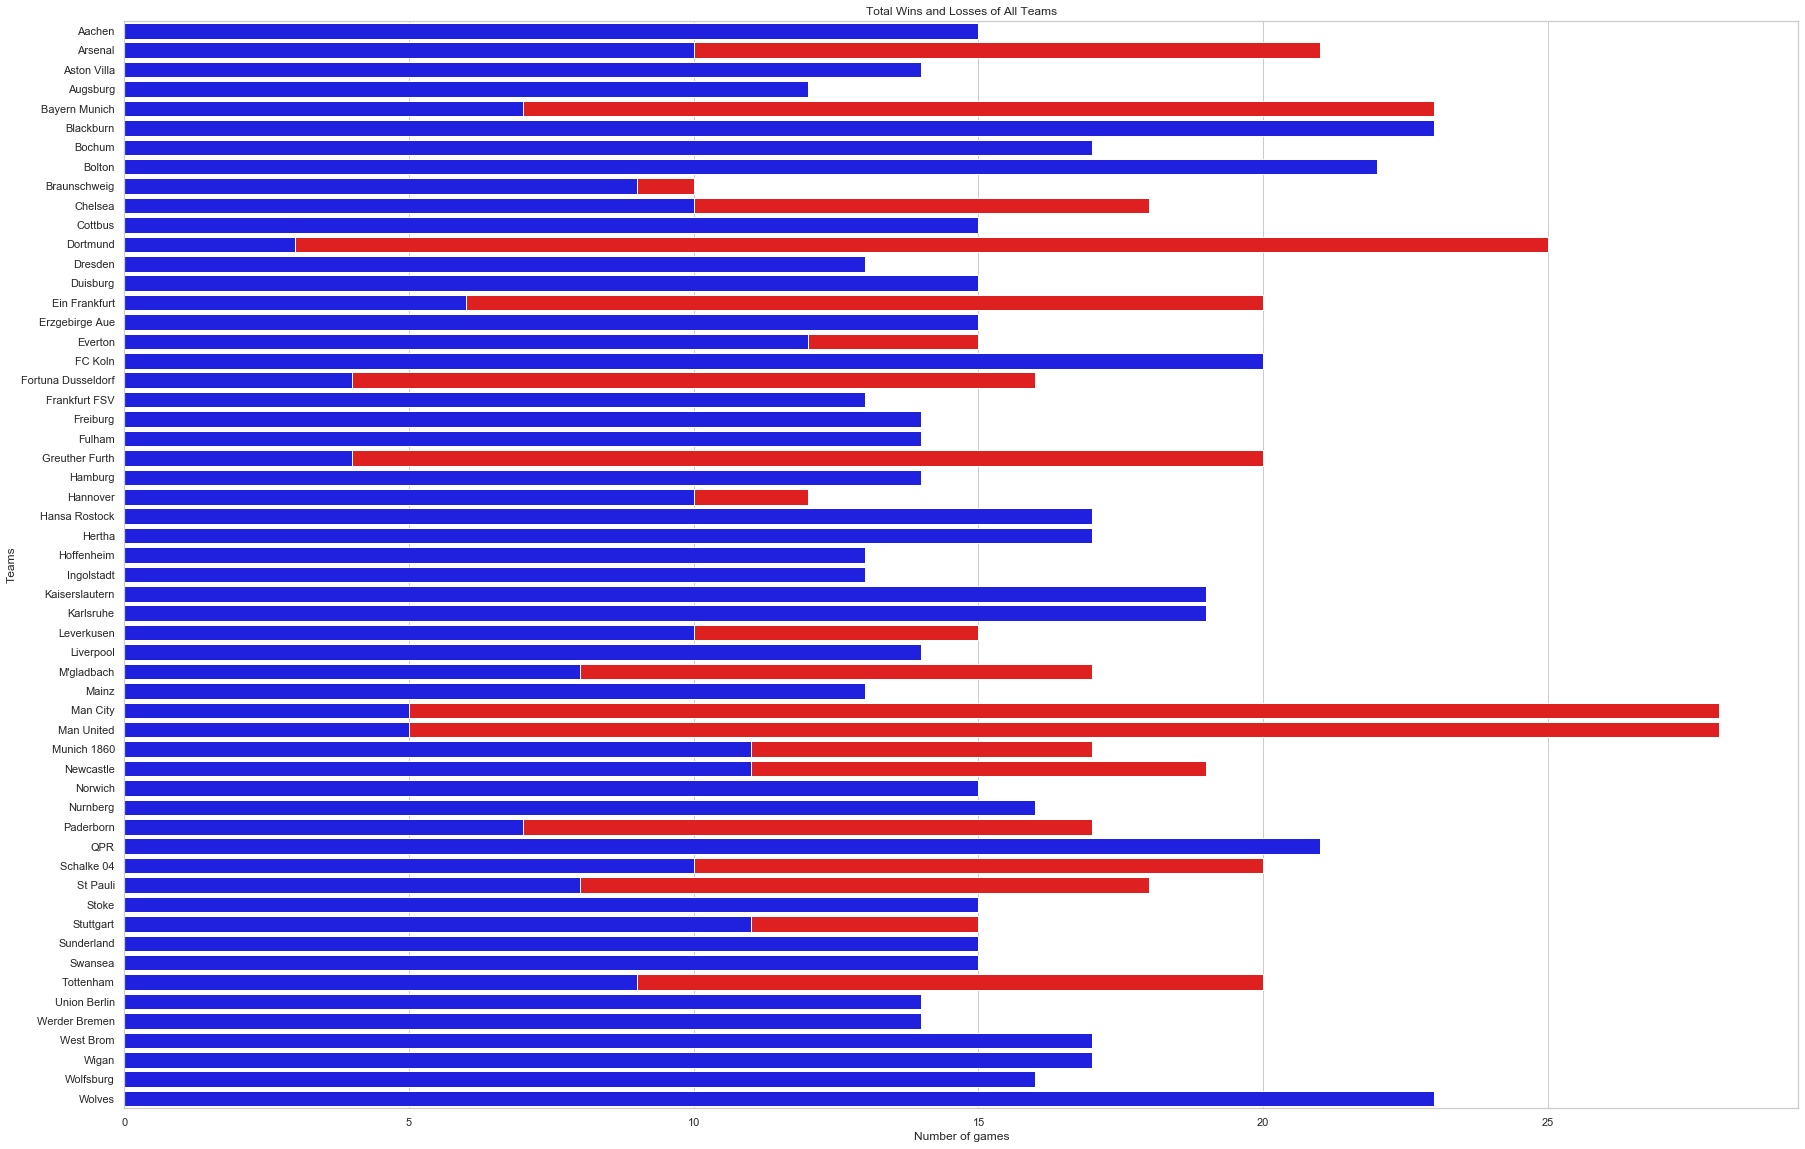

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(30,20))
ax = sns.barplot(x="Total_Wins" , y = "Team", data=big_query , color='red')
ax2 = sns.barplot(x='Total_Losses', y="Team", data=big_query, color ='blue')
plt.xlabel("Number of games")
plt.ylabel("Teams")
plt.title('Total Wins and Losses of All Teams' , fontsize = 12)
plt.show()

In [26]:
big_query.head()

,Team,Away_Goals,Home_Goals,Total_Goals,Away_Wins,Home_Wins,Total_Wins,Away_Draw,Home_Draw,Total_Draws,Total_Losses,Num_Games
0,Aachen,15,15,30,2,4,6,7,6,13,15,34
1,Arsenal,35,39,74,9,12,21,3,4,7,10,38
2,Aston Villa,17,20,37,3,4,7,10,7,17,14,38
3,Augsburg,16,20,36,2,6,8,7,7,14,12,34
4,Bayern Munich,28,49,77,9,14,23,3,1,4,7,34


# Histogram for team wins and Loses 

In [27]:
# fig, axes = plt.subplots(nrows = 2 , ncols = 2 , figsize= (10,10))
# ax0 , ax1 , ax2 , ax3 = axes.flatten()

# ax0.hist(big_query['Away_Wins'] , bins = 10 , color = 'red' , density = True)
# plt.title('Away_Wins')


# ax1.hist(big_query['Home_Wins'] , bins = 10 , color = 'k' , density = True)
# plt.title('Home_Wins')



# ax2.hist(big_query['Total_Wins'] , bins = 10 , color = 'c' , density = True)
# plt.title('Total_wins')


# ax3.hist(big_query['Total_Losses'] , bins = 10 , color = 'g' , density = True)
# plt.title('Total_Losses')
# plt.show()

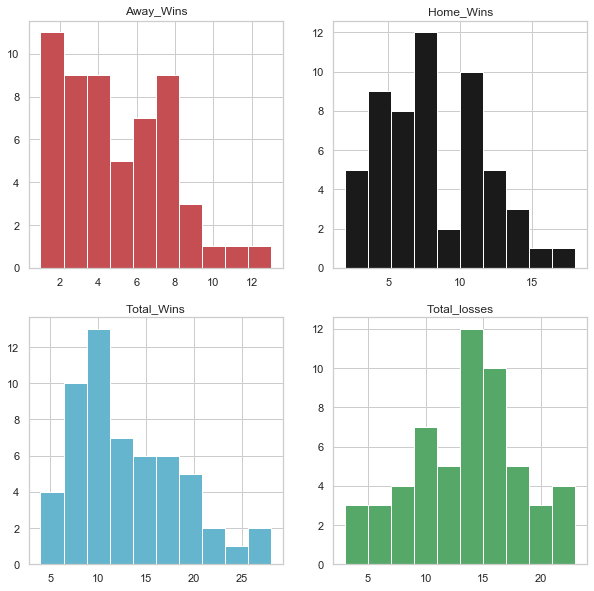

In [28]:
plt.figure(figsize = (10,10))
plt.subplot(221)
plt.title('Away_Wins')
plt.hist(big_query['Away_Wins'] , bins = 10 , color = 'r')


plt.subplot(222)
plt.title('Home_Wins')
plt.hist(big_query['Home_Wins'] , bins = 10 , color = 'k')

plt.subplot(223)
plt.title('Total_Wins')
plt.hist(big_query['Total_Wins'] , bins = 10 , color = 'c')

plt.subplot(224)
plt.title('Total_losses')
plt.hist(big_query['Total_Losses']  , color = 'g')
plt.savefig('Dashboard.png')


# Groupby Total Goals Visualisation

In [29]:
total_Team_Goals = big_query.groupby('Team').Total_Goals.sum() 
total_Team_Goals.head()

Team
Aachen           30
Arsenal          74
Aston Villa      37
Augsburg         36
Bayern Munich    77
Name: Total_Goals, dtype: int64

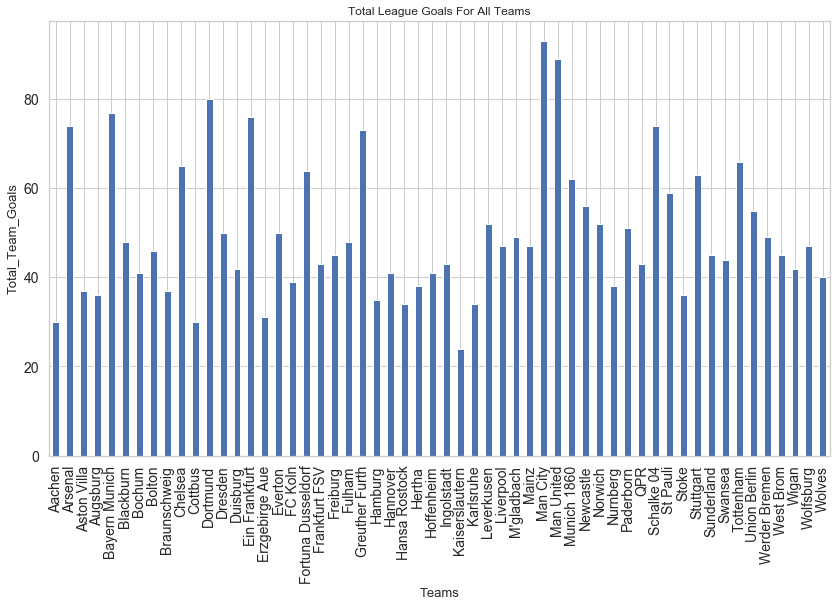

In [30]:
total_Team_Goals.plot(kind = 'bar' , figsize = (14,8) , fontsize = 14)
plt.xlabel("Teams" , fontsize = 13)
plt.ylabel("Total_Team_Goals" , fontsize = 13)
plt.title("Total League Goals For All Teams")
plt.show()

# Weather API Dates

In [31]:
cur.execute("""Select * 
               FROM Matches
               Where Season = 2011
               AND ((Div = 'D1' OR Div = 'D2'))
;""")
df2 = pd.DataFrame(cur.fetchall())
df2.columns = [x[0] for x in cur.description]
df2.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


# putting the dates in a dictionary

In [32]:
Date = list(df2.Date.unique())
len(Date)

136

In [33]:
Date

['2012-03-31',
 '2011-12-11',
 '2011-08-13',
 '2011-11-27',
 '2012-02-18',
 '2012-01-20',
 '2012-02-04',
 '2012-04-21',
 '2011-09-18',
 '2011-10-23',
 '2011-10-01',
 '2012-03-03',
 '2011-08-27',
 '2012-03-17',
 '2011-11-06',
 '2012-05-05',
 '2012-04-11',
 '2011-12-17',
 '2012-02-03',
 '2011-10-29',
 '2012-01-22',
 '2011-12-03',
 '2012-04-14',
 '2012-03-25',
 '2012-03-10',
 '2012-04-07',
 '2011-11-19',
 '2011-10-14',
 '2011-09-24',
 '2012-04-28',
 '2011-12-18',
 '2012-03-02',
 '2012-03-16',
 '2012-02-17',
 '2011-08-06',
 '2011-11-04',
 '2011-09-16',
 '2011-07-15',
 '2012-05-06',
 '2012-02-11',
 '2011-10-02',
 '2012-03-30',
 '2011-10-22',
 '2011-08-26',
 '2011-08-07',
 '2012-02-24',
 '2011-07-17',
 '2012-02-12',
 '2011-08-22',
 '2011-09-09',
 '2012-04-01',
 '2011-09-25',
 '2012-04-20',
 '2011-11-25',
 '2012-03-09',
 '2011-11-07',
 '2011-09-10',
 '2011-08-21',
 '2011-09-26',
 '2012-03-26',
 '2011-10-30',
 '2012-02-13',
 '2012-02-26',
 '2011-12-19',
 '2012-03-11',
 '2011-11-26',
 '2012-04-

# Import the weather API and match it with dates where Matches were played

In [34]:
#Uncomment And Run to initialize the API

# resp = requests.get("https://api.darksky.net/forecast/45c2523a2abba56c9086bf1bd12e36e1/52.5200,13.4050")
# resp.json()

In [35]:
resp = requests.get("https://api.darksky.net/forecast/90e2937454f78fc8a3aa3f6f0bcad17d/52.5200,13.4050,2011-12-11T12:00:00?currently,daily")
result = resp.json()

In [36]:
result.keys()

dict_keys(['latitude', 'longitude', 'timezone', 'currently', 'hourly', 'daily', 'flags', 'offset'])

In [37]:
result['daily'].keys()

dict_keys(['data'])

In [38]:
result['daily']['data'][0]['icon']

'partly-cloudy-day'

In [39]:
for key in result['daily'].keys():
    print(key, type(result['daily'][key]))

data <class 'list'>


# Previewing Weather

In [40]:
df = pd.DataFrame(result['daily']['data'])
df.head()

,time,summary,icon,sunriseTime,sunsetTime,moonPhase,precipIntensity,precipIntensityMax,precipProbability,temperatureHigh,...,uvIndexTime,visibility,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,1323558000,Mostly cloudy throughout the day.,partly-cloudy-day,1323587280,1323615240,0.54,0,0,0,41.55,...,1323601080,6.212,32.7,1323588960,41.55,1323605040,25.47,1323586860,34.94,1323605040


# checking the summary of in the weather API

In [41]:
result['daily']['data'][0]['summary']

'Mostly cloudy throughout the day.'

# Checking to confirm if Timezone Is Berlin

In [42]:
result['timezone']

'Europe/Berlin'

In [43]:
"https://api.darksky.net/forecast/{}/{},{},{}T12:00:00?exclude=currently,flag"

'https://api.darksky.net/forecast/{}/{},{},{}T12:00:00?exclude=currently,flag'

In [44]:
class WeatherGetter(object):
    """First initialised using Lat, Long data. By default latitude
    and long is of Berlin. Note there has been some changes in the
    API . Read Detrous/darksky on github. He fixed the summary issue
    a few days ago. Return to his github whenever you have any issues
    """
    def __init__(self, loc =["52.5200", "13.4050"]):
        self.lat = loc[0]
        self.long = loc[1]
        self.url ="https://api.darksky.net/forecast/90e2937454f78fc8a3aa3f6f0bcad17d/52.5200,13.4050,2011-12-11T12:00:00?exclude=currently,flag"" 
    def keys(self, path='/Users/flatironschool/.secret/darksky.json'):
        with open(path) as f:
            keys = json.load(f)
        return keys['api_key']
    def onDay(self, date):
        api_key = self.keys()
        resp = requests.get(self.url.format(api_key,self.lat,self.long, date))
        result = resp.json()
        try:
            weather = result['daily']['data'][0]['icon']
        except:
            try:
                weather = result['daily']['data'][0]['summary']
            except:
                weather = 'no data'
        return weather
    def for_days(self, datelist):
        weather = []
        for date in datelist:
            weather.append(self.onDay(date))
        return weather
    def test_one(self, date, cond='rain'):
        self.cond = cond
        weather_report = self.onDay(date)
        try:
            if cond in weather_report:
                return True
            else:
                return False
        except:
            return '?'
    def test_many(self, datelist, cond='rain'):
        weather_reports = {}
        for date in datelist:
            weather_reports[date] = self.test_one(date, cond)
        return weather_reports

SyntaxError: EOL while scanning string literal (<ipython-input-44-f44bb24d94d2>, line 10)

In [ ]:
weather = WeatherGetter()

weather_report = weather.test_many(Date)

# Note the weather will return a Boolean where when it rains it returns True else False¶

In [ ]:
weather_report

# creating a column for dates where it rained


In [ ]:
Rain_days = []
for date in df2.Date:
    Rain_days.append(weather_report[date])
    
df2['Rain_days'] = Rain_days 

In [ ]:
import pymongo

In [ ]:
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
mydb = myclient['example_database']